In [26]:
import torch
import time
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound
from botorch.models.transforms.outcome import Standardize
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
NOISE_SE = 0.25
nrep = 10
device = "cpu"

In [27]:
# the function to be maximized
from botorch.test_functions import Hartmann
neg_hartmann6 = Hartmann(negate = True)

In [28]:
def generate_initial_data(n):
    # generate training data
    train_x = torch.rand(n, 6, device=device, dtype=dtype)
    exact_obj = neg_hartmann6(train_x).unsqueeze(-1)  # add output dimension
    train_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    best_observed_value = train_x.max().item()
    return train_x, train_obj

In [29]:
neg_hartmann6

Hartmann()

In [30]:
# initialize training data and the model
train_X, train_Y = generate_initial_data(n=10)
outcome_transformer = Standardize( m = 1,
    batch_shape = torch.Size([]),
    min_stdv = 1e-08)
gp = SingleTaskGP(train_X, train_Y, outcome_transform = outcome_transformer)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll)
UCB = UpperConfidenceBound(gp, beta = 0.1)
bounds = torch.stack([torch.zeros(6, device = device), torch.ones(6, device = device)])
candidate, acq_value = optimize_acqf(
        UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )

In [31]:
best_seen_rep = []
time_list = []

for irep in range(nrep):
    
    train_X, train_Y = generate_initial_data(n = 10)
    
    outcome_transformer = Standardize( m = 1,
        batch_shape = torch.Size([]),
        min_stdv = 1e-08)
    
    gp = SingleTaskGP(train_X, train_Y, outcome_transform = outcome_transformer)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    bounds = torch.stack([torch.zeros(6, device = device), torch.ones(6, device = device)])
    best_observed_value = []
    t0 = time.time()
    
    for iteration in range(40):

        fit_gpytorch_model(mll)

        UCB = UpperConfidenceBound(gp, beta = 2)    
        candidate, acq_value = optimize_acqf(
            UCB, bounds=bounds, q = 1, num_restarts=5, raw_samples=20,
        )
        new_x = candidate.detach()
        print(new_x)
        new_y = neg_hartmann6(new_x).unsqueeze(-1)
        new_y = new_y + NOISE_SE * torch.randn_like(new_y)
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y])
        best_value = neg_hartmann6(train_X).max()
        best_observed_value.append(best_value.cpu())

        # update GP model using dataset with new datapoint
        gp = SingleTaskGP(train_X, train_Y)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)


        print(
                f"\nBatch {iteration:>2}: best_value = "
                f"({best_value:>4.2f}), "
            )
    time_list.append(time.time() - t0)
    best_seen_rep.append(np.array(best_observed_value))

tensor([[0.2527, 0.9187, 0.5734, 0.4610, 0.2186, 0.2771]])

Batch  0: best_value = (1.41), 
tensor([[0.2714, 0.9846, 0.8034, 0.5522, 0.0810, 0.1574]])

Batch  1: best_value = (1.78), 
tensor([[0.2732, 0.9886, 0.8973, 0.5872, 0.0596, 0.1207]])

Batch  2: best_value = (1.98), 
tensor([[0.2843, 0.9354, 0.9831, 0.6135, 0.1472, 0.1174]])

Batch  3: best_value = (2.21), 
tensor([[0.2479, 0.8925, 0.9780, 0.6930, 0.0218, 0.1351]])

Batch  4: best_value = (2.21), 
tensor([[0.3071, 1.0000, 1.0000, 0.5493, 0.1579, 0.0396]])

Batch  5: best_value = (2.42), 
tensor([[0.4007, 1.0000, 1.0000, 0.4854, 0.1666, 0.0000]])

Batch  6: best_value = (2.59), 
tensor([[0.3590, 1.0000, 1.0000, 0.3709, 0.1993, 0.0000]])

Batch  7: best_value = (2.59), 
tensor([[0.4897, 1.0000, 1.0000, 0.5453, 0.1393, 0.0000]])

Batch  8: best_value = (2.59), 
tensor([[0.3775, 0.9007, 1.0000, 0.5133, 0.1050, 0.0000]])

Batch  9: best_value = (2.97), 
tensor([[0.3848, 0.9851, 1.0000, 0.5118, 0.2819, 0.0000]])

Batch 10: best_value

tensor([[0.4625, 0.4070, 0.8244, 0.0000, 0.2435, 0.8439]])

Batch 10: best_value = (1.45), 
tensor([[0.3783, 0.3090, 0.8662, 0.0000, 0.2455, 0.8826]])

Batch 11: best_value = (1.45), 
tensor([[0.4097, 0.3761, 0.8479, 0.0000, 0.2533, 0.8982]])

Batch 12: best_value = (1.45), 
tensor([[0.4193, 0.2734, 0.8323, 0.0000, 0.2358, 0.8041]])

Batch 13: best_value = (1.45), 
tensor([[0.4155, 0.2519, 0.8234, 0.0000, 0.2347, 0.7384]])

Batch 14: best_value = (1.45), 
tensor([[0.4063, 0.2342, 0.8572, 0.0000, 0.2254, 0.8605]])

Batch 15: best_value = (1.45), 
tensor([[0.4644, 0.3506, 0.7930, 0.0000, 0.2601, 0.7226]])

Batch 16: best_value = (1.45), 
tensor([[0.4089, 0.3248, 0.8344, 0.0939, 0.2425, 0.8652]])

Batch 17: best_value = (1.53), 
tensor([[0.4037, 0.3291, 0.8359, 0.1339, 0.2417, 0.8650]])

Batch 18: best_value = (1.65), 
tensor([[0.3836, 0.3332, 0.8371, 0.2201, 0.2413, 0.8698]])

Batch 19: best_value = (1.85), 
tensor([[0.3510, 0.3470, 0.8382, 0.2898, 0.2371, 0.8753]])

Batch 20: best_value

tensor([[0.3796, 0.9095, 0.3628, 0.5676, 0.4245, 0.0690]])

Batch 20: best_value = (3.08), 
tensor([[0.3790, 0.9132, 0.3611, 0.5635, 0.4245, 0.0850]])

Batch 21: best_value = (3.08), 
tensor([[0.3756, 0.9059, 0.3518, 0.5659, 0.4116, 0.0000]])

Batch 22: best_value = (3.08), 
tensor([[0.4035, 0.8532, 0.4040, 0.6038, 0.4455, 0.0286]])

Batch 23: best_value = (3.08), 
tensor([[0.3932, 0.9046, 0.3955, 0.5953, 0.4297, 0.0000]])

Batch 24: best_value = (3.08), 
tensor([[0.4083, 0.8718, 0.3442, 0.5751, 0.4375, 0.0420]])

Batch 25: best_value = (3.12), 
tensor([[0.4151, 0.8710, 0.3375, 0.5733, 0.4364, 0.0453]])

Batch 26: best_value = (3.12), 
tensor([[0.4197, 0.8741, 0.3364, 0.5711, 0.4320, 0.0310]])

Batch 27: best_value = (3.12), 
tensor([[0.3989, 0.8564, 0.4232, 0.5748, 0.4086, 0.0509]])

Batch 28: best_value = (3.12), 
tensor([[0.3981, 0.8399, 0.4585, 0.5741, 0.3960, 0.0546]])

Batch 29: best_value = (3.12), 
tensor([[0.4005, 0.9178, 0.3585, 0.5896, 0.4313, 0.0547]])

Batch 30: best_value

tensor([[0.1081, 0.7032, 0.7095, 0.2377, 0.3360, 0.6266]])

Batch 30: best_value = (1.03), 
tensor([[0.2125, 0.6326, 0.7190, 0.3064, 0.3542, 0.5782]])

Batch 31: best_value = (1.13), 
tensor([[0.1974, 0.5993, 0.7219, 0.3190, 0.3454, 0.5471]])

Batch 32: best_value = (1.19), 
tensor([[0.1873, 0.6157, 0.7271, 0.3194, 0.3579, 0.6979]])

Batch 33: best_value = (1.27), 
tensor([[0.1807, 0.5985, 0.7266, 0.2456, 0.3753, 0.6854]])

Batch 34: best_value = (1.31), 
tensor([[0.1982, 0.6100, 0.7126, 0.2538, 0.3482, 0.7915]])

Batch 35: best_value = (1.31), 
tensor([[0.2067, 0.6066, 0.7385, 0.1890, 0.3435, 0.8586]])

Batch 36: best_value = (1.31), 
tensor([[0.1958, 0.5854, 0.6969, 0.3535, 0.3526, 0.7994]])

Batch 37: best_value = (1.34), 
tensor([[0.1927, 0.5745, 0.6911, 0.2745, 0.3425, 0.7629]])

Batch 38: best_value = (1.53), 
tensor([[0.2020, 0.6186, 0.7021, 0.4014, 0.3648, 0.8892]])

Batch 39: best_value = (1.53), 
tensor([[0.1350, 0.3909, 0.7056, 0.4042, 0.3014, 0.5506]])

Batch  0: best_value

tensor([[0.2171, 0.2248, 0.6070, 0.4164, 0.4241, 0.7849]])

Batch  1: best_value = (1.92), 
tensor([[0.1897, 0.2548, 0.5652, 0.4030, 0.3446, 0.7999]])

Batch  2: best_value = (2.31), 
tensor([[0.1515, 0.2797, 0.5172, 0.3795, 0.2567, 0.8362]])

Batch  3: best_value = (2.31), 
tensor([[0.2413, 0.2850, 0.5668, 0.4310, 0.3357, 0.7440]])

Batch  4: best_value = (2.31), 
tensor([[0.2268, 0.2616, 0.4866, 0.4070, 0.3547, 0.8383]])

Batch  5: best_value = (2.31), 
tensor([[0.1740, 0.3023, 0.6239, 0.4049, 0.3297, 0.7699]])

Batch  6: best_value = (2.31), 
tensor([[0.1357, 0.2492, 0.6982, 0.3608, 0.3292, 0.7709]])

Batch  7: best_value = (2.41), 
tensor([[0.1206, 0.3898, 0.6368, 0.4410, 0.3399, 0.7851]])

Batch  8: best_value = (2.41), 
tensor([[0.2018, 0.2902, 0.6549, 0.3250, 0.3388, 0.7593]])

Batch  9: best_value = (2.60), 
tensor([[0.1637, 0.2601, 0.6736, 0.4646, 0.3210, 0.7367]])

Batch 10: best_value = (2.60), 
tensor([[0.2430, 0.2862, 0.6624, 0.3902, 0.3306, 0.7790]])

Batch 11: best_value

In [32]:
np.save('Hartmann6_SNR4_UCB2-0_10Prior_10reps_standardize.npy', np.array(best_seen_rep))

In [58]:
np.mean(time_list)

20.51214556694031

## Compare between results from BOtorch and SLAC GP

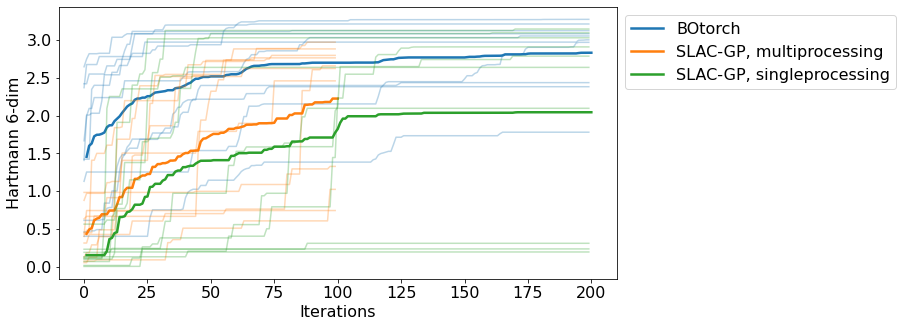

In [34]:
fig, ax = plt.subplots(1,1, figsize = [10, 5])
result_path = '/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/'

result = np.load('Hartmann6_SNR2_UCB2-0_10Prior_10reps_200iter.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
niter = result.shape[1]
ax.plot(np.linspace(1,200, 200), avg, linewidth = 2.5, label = 'BOtorch')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(result[i,:niter], c='C0', alpha = 0.3)
    
result = np.load(result_path + 'Hartmann6_SNR2_UCB2-0_multi_10reps_100iter.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
ax.plot(np.linspace(1,100,100), avg, linewidth = 2.5, c = 'C1', label = 'SLAC-GP, multiprocessing')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(result[i,:], c = 'C1', alpha = 0.3)
    
result = np.load(result_path + 'Hartmann6_SNR2_UCB2-0_single_10reps_200iter.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
ax.plot(np.linspace(1,200,200), avg, linewidth = 2.5, c = 'C2', label = 'SLAC-GP, singleprocessing')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(result[i,:], c = 'C2', alpha = 0.3)
    
ax.set_xlabel('Iterations',fontsize = 16)
ax.set_ylabel('Hartmann 6-dim', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize = 16)

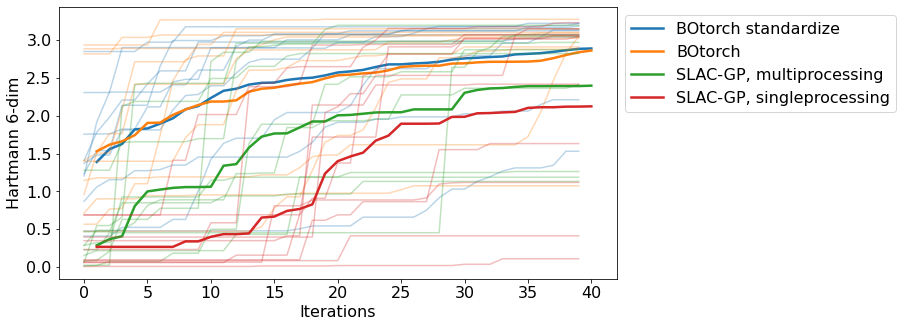

In [35]:
fig, ax = plt.subplots(1,1, figsize = [10, 5])
result_path = '/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/'

result = np.load('Hartmann6_SNR4_UCB2-0_10Prior_10reps_standardize.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
ax.plot(np.linspace(1,40,40), avg, linewidth = 2.5, label = 'BOtorch standardize')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(result[i,:], c='C0', alpha = 0.3)
    
result = np.load('Hartmann6_SNR4_UCB2-0_10Prior_10reps.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
ax.plot(np.linspace(1,40,40), avg, linewidth = 2.5, c = 'C1', label = 'BOtorch')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(result[i,:], c='C1', alpha = 0.3)
    
result = np.load(result_path + 'Hartmann6_SNR4_UCB2-0_multi_10reps.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
ax.plot(np.linspace(1,40,40), avg, linewidth = 2.5, c = 'C2', label = 'SLAC-GP, multiprocessing')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(result[i,:], c = 'C2', alpha = 0.3)
    
result = np.load(result_path + 'Hartmann6_SNR4_UCB2-0_single_10reps.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
ax.plot(np.linspace(1,40,40), avg, linewidth = 2.5, c='C3', label = 'SLAC-GP, singleprocessing')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(result[i,:], c = 'C3', alpha = 0.3)
    
# result = np.load(result_path + 'Hartmann6_SNR2_falseUCB2-0_multi_10reps.npy')
# avg = np.mean(result, axis = 0)
# std = np.std(result, axis = 0)
# ax.plot(np.linspace(1,40,40), avg, linewidth = 2.5, c = 'C3', label = 'SLAC-GP, multiprocessing, false UCB')
# # ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
# for i in range(result.shape[0]):
#     ax.plot(result[i,:], c='C3', alpha = 0.3)

ax.set_xlabel('Iterations',fontsize = 16)
ax.set_ylabel('Hartmann 6-dim', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize = 16)